In [89]:
import urllib3
from urllib3 import request
import certifi
import json
import pandas as pd
import numpy as np
import time 
import datetime 

import seaborn as sns

sns.set(style="whitegrid", palette="muted")
pal = { 1:"seagreen", 0:"gray" }

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [6]:
http = urllib3.PoolManager(
       cert_reqs='CERT_REQUIRED',
       ca_certs=certifi.where())

In [7]:
url = 'CAMUNDA_HOST/rest/history/incident'
r = http.request('GET', url)

In [8]:
data = json.loads(r.data.decode('utf-8'))
df = pd.json_normalize(data)
# df.head(5)
df.describe()

,id,processDefinitionKey,processDefinitionId,processInstanceId,executionId,rootProcessInstanceId,createTime,endTime,removalTime,incidentType,activityId,causeIncidentId,rootCauseIncidentId,configuration,incidentMessage,tenantId,jobDefinitionId,open,deleted,resolved
count,7381,7358,7358,7370,7370,7370,7381,6510,0,7381,7371,7381,7381,6250,6243,0,5,7381,7381,7381
unique,7381,66,155,4116,4524,3494,7367,6436,0,2,221,6396,6250,3917,5629,0,4,2,2,2
top,fdab052f-cb05-11ea-945b-b22139c8503d,Process_0umor6i,Process_0umor6i:2:109f8099-6f65-11ea-be0d-caa7...,ddab7401-5c88-11ea-9290-16e3bcf3a6cd,49a18d98-5d37-11ea-9290-16e3bcf3a6cd,ddab7401-5c88-11ea-9290-16e3bcf3a6cd,2020-08-12T11:44:44.855+0600,2020-08-10T22:11:15.469+0600,NaN,failedExternalTask,Task_1l187g1,66fe0907-bfbd-11ea-b8e4-b6716fbc6bb5,8b61ad29-b147-11ea-a02c-06760e9ef522,49a1b4ac-5d37-11ea-9290-16e3bcf3a6cd,Transaction rolled back because it has been ma...,NaN,e4936407-8af0-11ea-a042-469bf0b134df,False,False,True
freq,1,1905,1493,137,137,137,3,2,NaN,7344,850,2,5,137,12,NaN,2,6510,7146,6275


In [217]:
# first incident date
min(df['createTime'])

Timestamp('2019-11-30 00:01:14.094000+0600', tz='pytz.FixedOffset(360)')

In [219]:
# last incident date
max(df['createTime'])

Timestamp('2020-08-20 17:30:39.314000+0600', tz='pytz.FixedOffset(360)')

In [223]:
# total number of incidents
df.shape[0]

7381

In [72]:
# df.loc[df['processDefinitionKey'] == 'Process_0umor6i'].values[0][2]
mostDefinitions = df['%processDefinitionKey'].value_counts().nlargest(10)
leastDefinitions = df['processDefinitionKey'].value_counts().nsmallest(10)

In [77]:
def incidentsByProcDefKeyBarPlot(defs, title):
    plt.figure(figsize=(22,16))
    ax = sns.barplot(x = defs.index, 
                       y = defs,
                       linewidth=2)

    ax.set_xlabel("processDefinitionKey",fontsize=30)
    ax.set_ylabel("Кол-во Инцидентов",fontsize=30)

    ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
    plt.tight_layout()

    sns.set(font_scale = 2)

    for p in ax.patches:
        ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center'
                   , fontsize=22, color='gray', xytext=(0, 20),
                     textcoords='offset points')

    plt.title(title, fontsize = 45)
    plt.show()

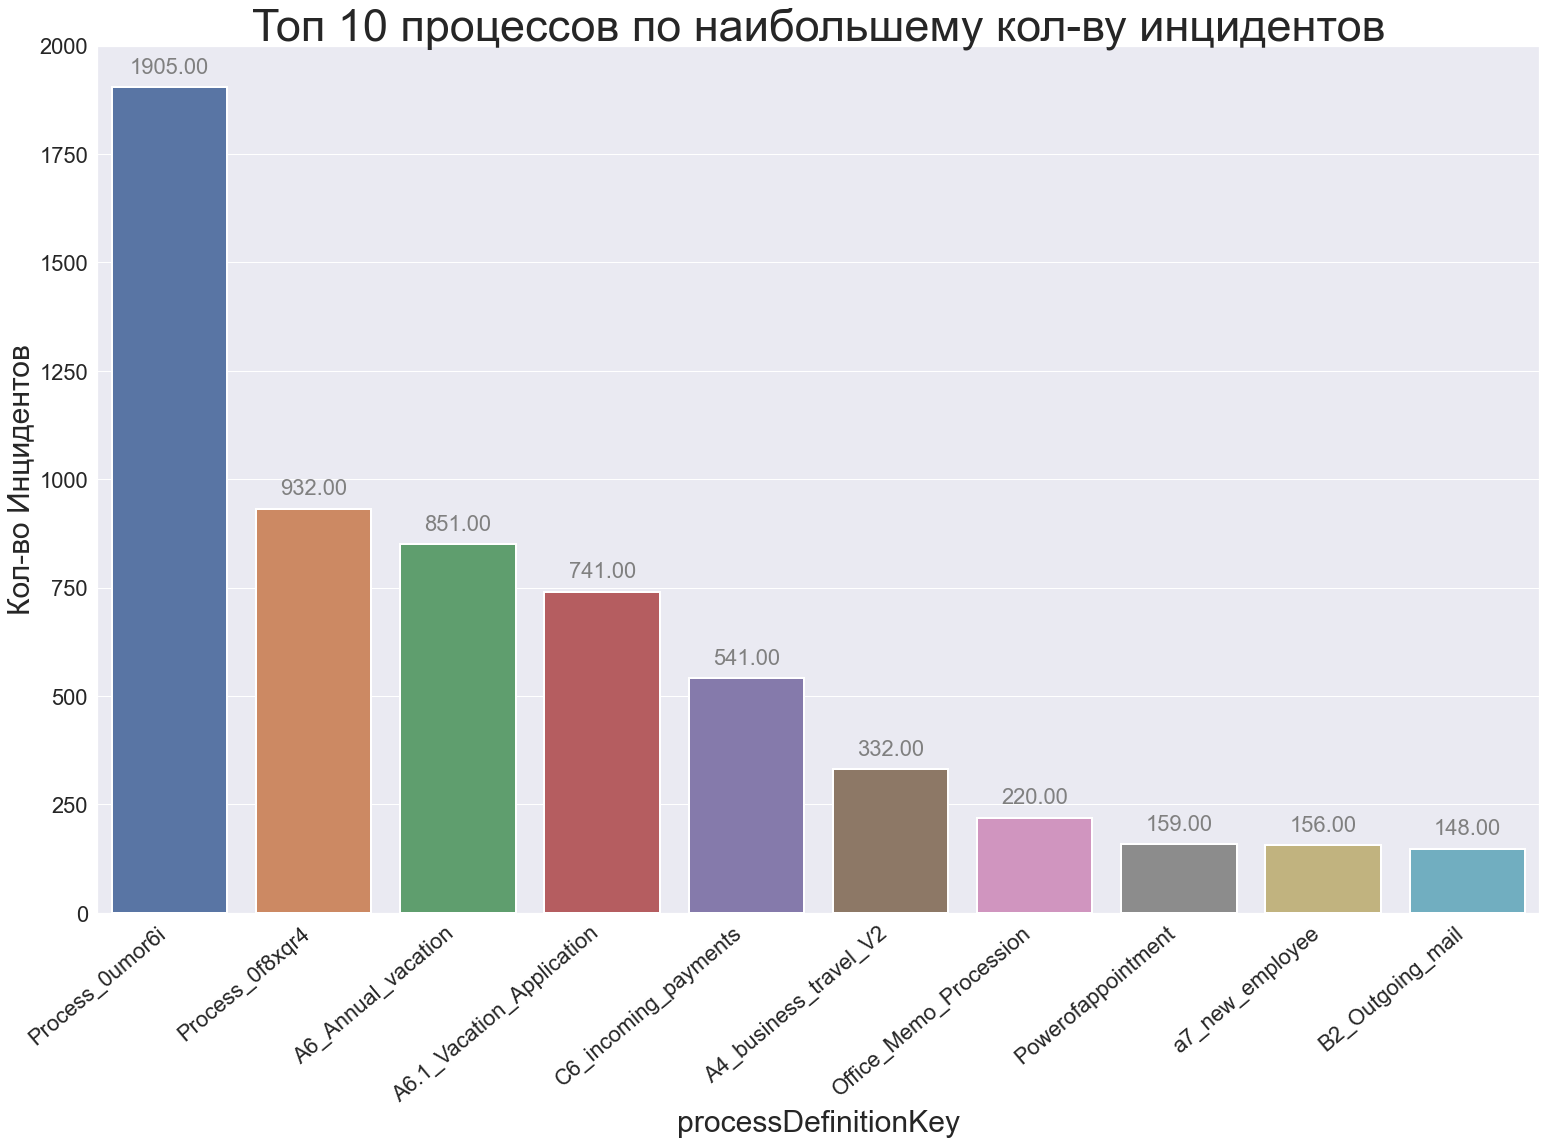

In [81]:
incidentsByProcDefKeyBarPlot(mostDefinitions, "Top 10 processes by incidents")

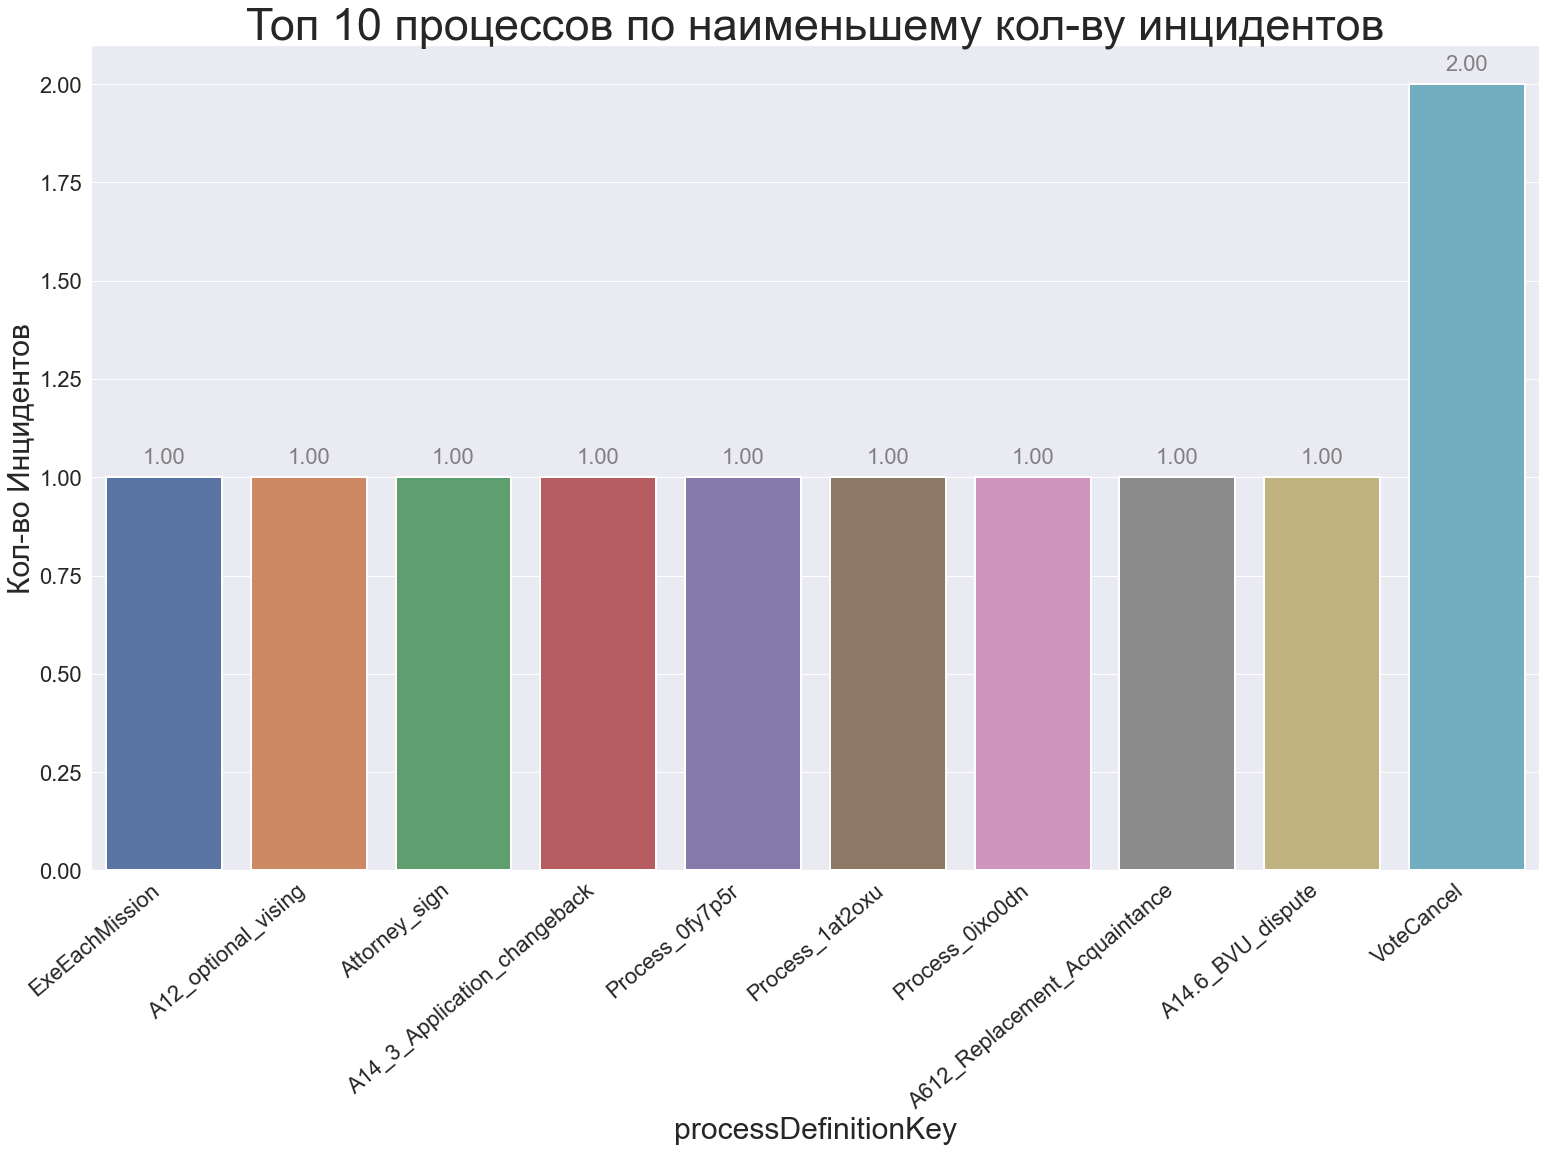

In [80]:
incidentsByProcDefKeyBarPlot(leastDefinitions, "Least 10 processes by incidents")

In [163]:
# Parsing time string to date
df['createDate'] = pd.to_datetime(df['createTime'], errors='coerce').dt.date
df['endDate'] = pd.to_datetime(df['endTime'], errors='coerce').dt.date
df['createTime'] = pd.to_datetime(df['createTime'])
df['endTime'] = pd.to_datetime(df['endTime'])
df['delta_time'] = df.endTime - df.createTime

createDateDf = df.groupby('createDate').count()

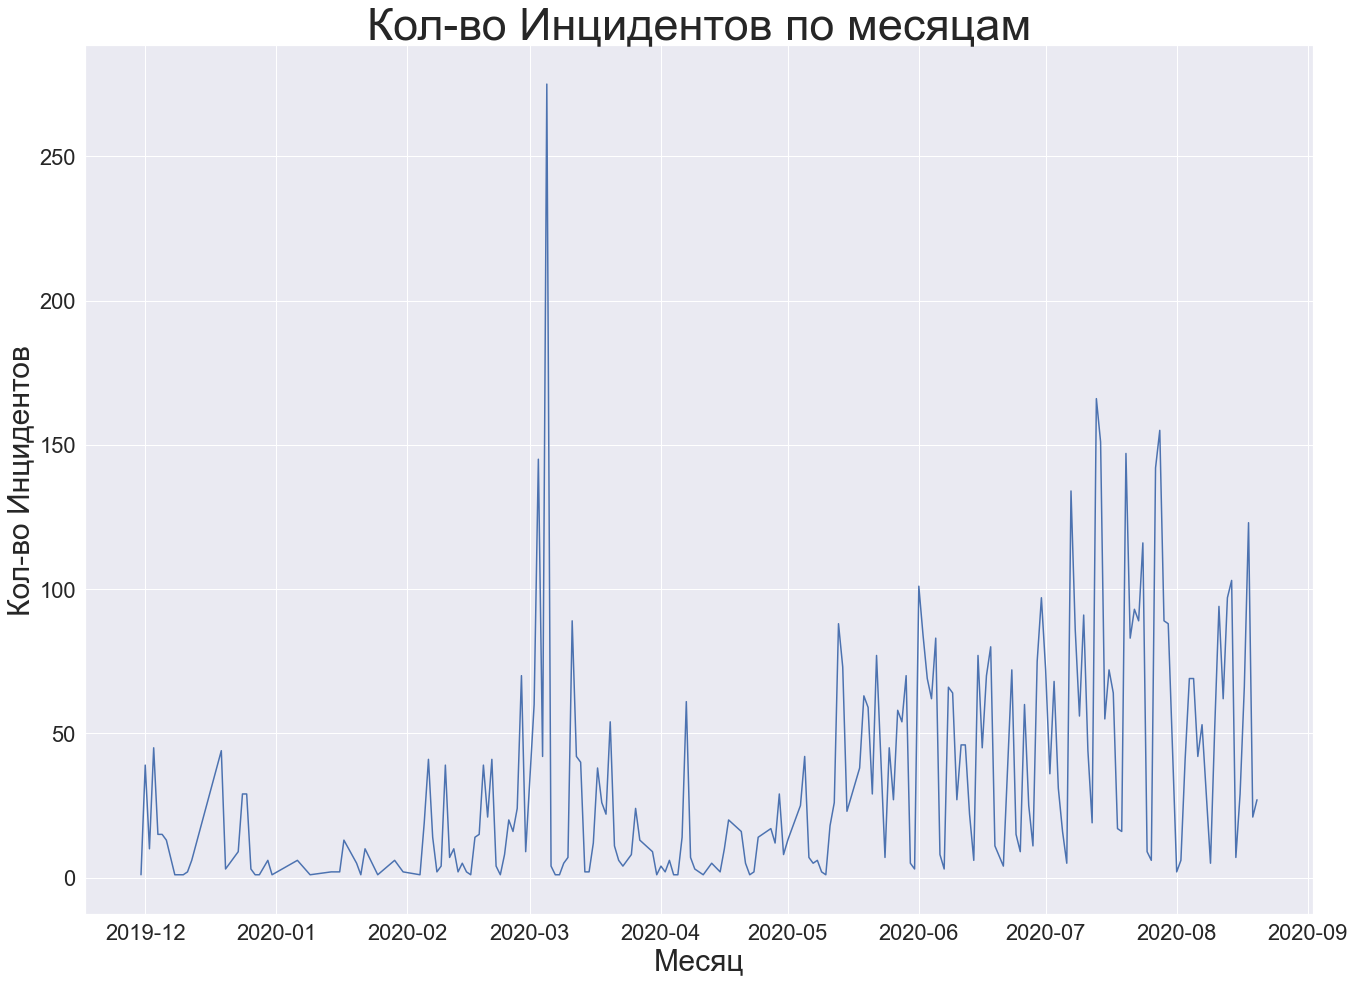

In [84]:
plt.figure(figsize=(22,16))
ax = sns.lineplot(data=createDateDf, x='createDate', y='id')

ax.set_xlabel("Month",fontsize=30)
ax.set_ylabel("Incidents count",fontsize=30)

plt.title("Number of inccidents by months", fontsize = 45)

plt.show()

In [121]:
clearedDeltaTime = df[df.delta_time.isnull() == False]
clearedDeltaTimeExTask = df[df.incidentType == 'failedExternalTask']
clearedDeltaTimeJob = df[df.incidentType == 'failedJob']

In [122]:
secondsMeanExTask = (clearedDeltaTimeExTask.delta_time.dt.seconds).mean()
secondsExTask = int(secondsMeanExTask)
str(datetime.timedelta(seconds=secondsExTask))

'5:49:31'

In [123]:
secondsMeanJob = (clearedDeltaTimeJob.delta_time.dt.seconds).mean()
secondsJob = int(secondsMeanJob)
str(datetime.timedelta(seconds=secondsJob))

'14:34:31'

In [136]:
# mean time, grouped by incident type
deltaTimeMeanDf = pd.DataFrame({
    'type': ['failedExternalTask', 'failedJob'],
    'timesec': [secondsExTask, secondsJob]
})

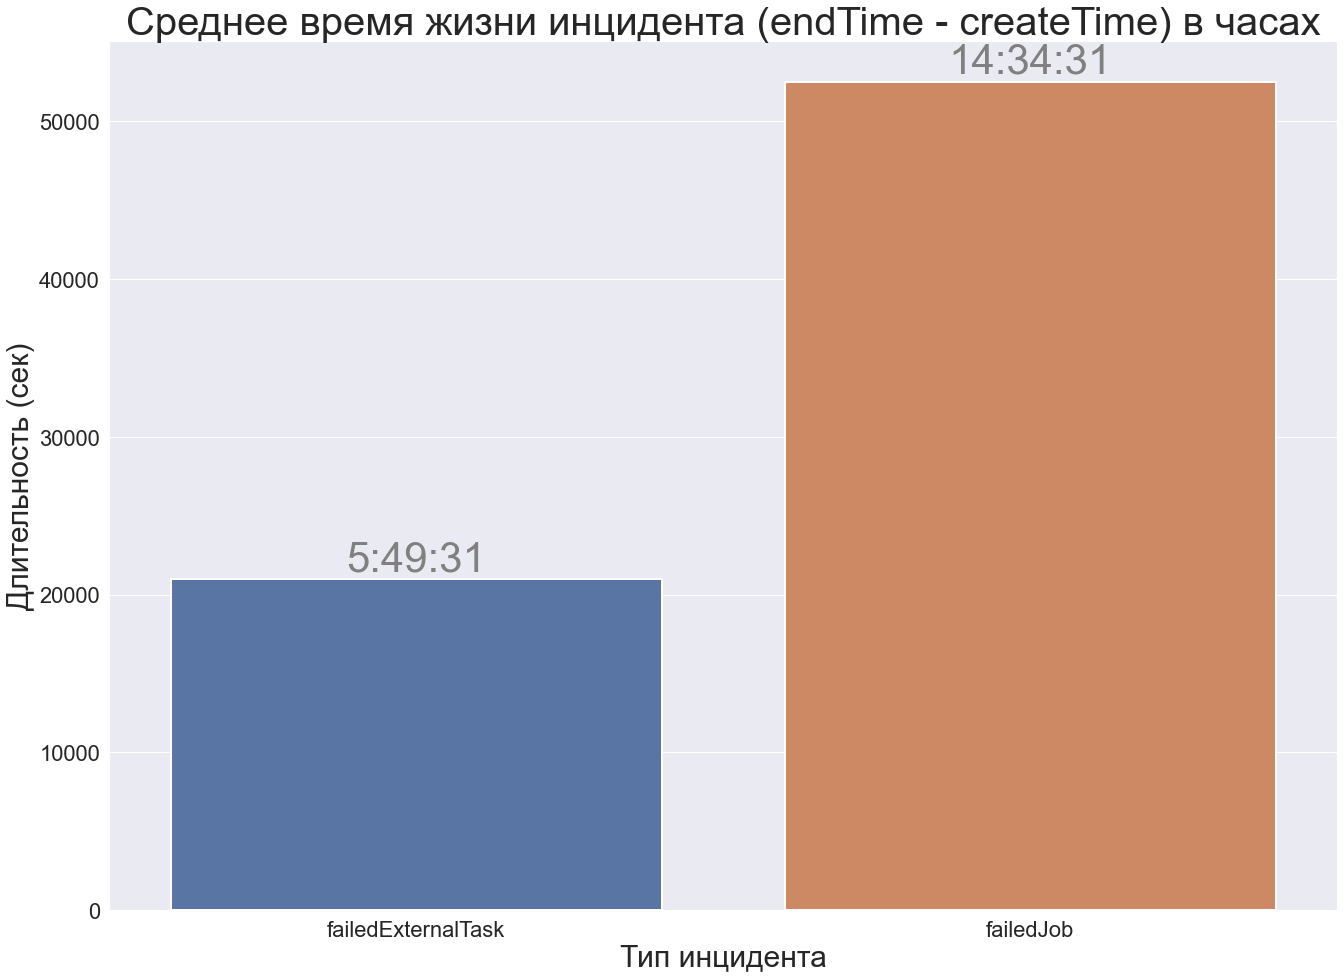

In [153]:
plt.figure(figsize=(22,16))
ax = sns.barplot(x = 'type', y = 'timesec', data=deltaTimeMeanDf, linewidth=2)

ax.set_xlabel("Incident type",fontsize=30)
ax.set_ylabel("Duration (sec)",fontsize=30)

sns.set(font_scale = 2)

for p in ax.patches:
    ax.annotate(str(datetime.timedelta(seconds=p.get_height())), (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', 
                va='center',
                fontsize=42, 
                color='gray', 
                xytext=(0, 20),
                textcoords='offset points')

plt.title("Mean incident lifetime (endTime - createTime) in hours", fontsize = 40)
plt.show()

In [171]:
clearedDeltaTime['delta_time_sec'] = clearedDeltaTime['delta_time'].dt.total_seconds()
clearedDeltaTime['delta_time_minutes'] = clearedDeltaTime['delta_time_sec'].apply(lambda x: int(round(x / 60)))

/Users/Sanzhar/miniconda3/envs/jupyter_env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/Sanzhar/miniconda3/envs/jupyter_env/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,id,processDefinitionKey,processDefinitionId,processInstanceId,executionId,rootProcessInstanceId,createTime,endTime,removalTime,incidentType,...,incidentMessage,tenantId,jobDefinitionId,open,deleted,resolved,createDate,delta_time,delta_time_sec,delta_time_minutes
1,001840ac-c689-11ea-b173-f64402c3b171,Process_0umor6i,Process_0umor6i:2:109f8099-6f65-11ea-be0d-caa7...,fb8a7bb3-c688-11ea-b173-f64402c3b171,fdd0c1a6-c688-11ea-b173-f64402c3b171,fb8a7bb3-c688-11ea-b173-f64402c3b171,2020-07-15 16:50:30.263000+06:00,2020-07-15 16:50:54.155000+06:00,None,failedExternalTask,...,"{""status"":500,""series"":16,""timestamp"":""Jul 15,...",None,None,False,False,True,2020-07-15,0 days 00:00:23.892000,23.892,0
2,002350ca-b0cd-11ea-a02c-06760e9ef522,SignProt,SignProt:4:97bd3200-32cb-11ea-a776-be3653bc21b8,bed22c74-3da3-11ea-8b04-42d5d912c957,86d1edb6-4246-11ea-8b04-42d5d912c957,feb42aa6-3d8b-11ea-8b04-42d5d912c957,2020-06-18 01:01:50.532000+06:00,2020-07-20 15:07:55.375000+06:00,None,failedExternalTask,...,"{""status"":500,""series"":15,""timestamp"":""Jun 18,...",None,None,False,False,True,2020-06-18,32 days 14:06:04.843000,2815564.843,46926
3,00239eeb-b0cd-11ea-a02c-06760e9ef522,A3UKOmeeting,A3UKOmeeting:4:7bd5a3ea-32cb-11ea-a776-be3653b...,feb42aa6-3d8b-11ea-8b04-42d5d912c957,bed07f46-3da3-11ea-8b04-42d5d912c957,feb42aa6-3d8b-11ea-8b04-42d5d912c957,2020-06-18 01:01:50.534000+06:00,2020-07-20 15:07:55.374000+06:00,None,failedExternalTask,...,None,None,None,False,False,True,2020-06-18,32 days 14:06:04.840000,2815564.840,46926
4,0042f5fb-2549-11ea-bf45-5a180f596d6e,A4_business_travel_V2,A4_business_travel_V2:5:a7af3cab-1760-11ea-907...,16846f95-2180-11ea-bf45-5a180f596d6e,ed477e7d-2548-11ea-bf45-5a180f596d6e,16846f95-2180-11ea-bf45-5a180f596d6e,2019-12-23 11:56:45.545000+06:00,2019-12-24 18:06:49.281000+06:00,None,failedExternalTask,...,"{""status"":500,""series"":15,""timestamp"":""Dec 23,...",None,None,False,False,True,2019-12-23,1 days 06:10:03.736000,108603.736,1810
5,004d56f5-6a39-11ea-810d-060e3c8d23d5,a7_new_employee,a7_new_employee:3:ceb1d3bf-5eea-11ea-b510-3685...,b721483c-62ac-11ea-b510-368569dc882f,59a2c4e5-637e-11ea-b510-368569dc882f,b721483c-62ac-11ea-b510-368569dc882f,2020-03-20 05:26:03.897000+06:00,2020-03-20 05:58:38.515000+06:00,None,failedExternalTask,...,"{""status"":500,""series"":7,""timestamp"":""Mar 20, ...",None,None,False,False,True,2020-03-20,0 days 00:32:34.618000,1954.618,33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7375,ffc43e38-c027-11ea-b8e4-b6716fbc6bb5,Process_0umor6i,Process_0umor6i:2:109f8099-6f65-11ea-be0d-caa7...,fb39fbdd-c027-11ea-b8e4-b6716fbc6bb5,ff76ba72-c027-11ea-b8e4-b6716fbc6bb5,fb39fbdd-c027-11ea-b8e4-b6716fbc6bb5,2020-07-07 14:01:01.553000+06:00,2020-07-07 14:08:14.392000+06:00,None,failedExternalTask,...,"{""status"":500,""series"":16,""timestamp"":""Jul 7, ...",None,None,False,False,True,2020-07-07,0 days 00:07:12.839000,432.839,7
7376,ffdfb9f1-2258-11ea-bf45-5a180f596d6e,A4_business_travel_V2,A4_business_travel_V2:5:a7af3cab-1760-11ea-907...,b80c58b8-2256-11ea-bf45-5a180f596d6e,0acce33f-2257-11ea-bf45-5a180f596d6e,b80c58b8-2256-11ea-bf45-5a180f596d6e,2019-12-19 18:13:43.354000+06:00,2019-12-19 18:19:20.562000+06:00,None,failedExternalTask,...,"{""status"":500,""series"":5,""timestamp"":""Dec 19, ...",None,None,False,False,True,2019-12-19,0 days 00:05:37.208000,337.208,6
7377,ffe90a83-db84-11ea-89ab-beacb3148b9a,B2_Approve,B2_Approve:3:e36f2a95-d8cd-11ea-89ab-beacb3148b9a,f93b99d9-db84-11ea-89ab-beacb3148b9a,f93bc0ff-db84-11ea-89ab-beacb3148b9a,9fdd7734-d861-11ea-89ab-beacb3148b9a,2020-08-11 09:44:46.385000+06:00,2020-08-11 11:13:36.419000+06:00,None,failedExternalTask,...,"{""status"":500,""series"":0,""timestamp"":""Aug 11, ...",None,None,False,False,True,2020-08-11,0 days 01:28:50.034000,5330.034,89
7378,ffe958a4-db84-11ea-89ab-beacb3148b9a,B2_Outgoing_mail,B2_Outgoing_mail:2:1b416584-d7e3-11ea-9acf-b22...,9fdd7734-d861-11ea-89ab-beacb3148b9a,f93aa

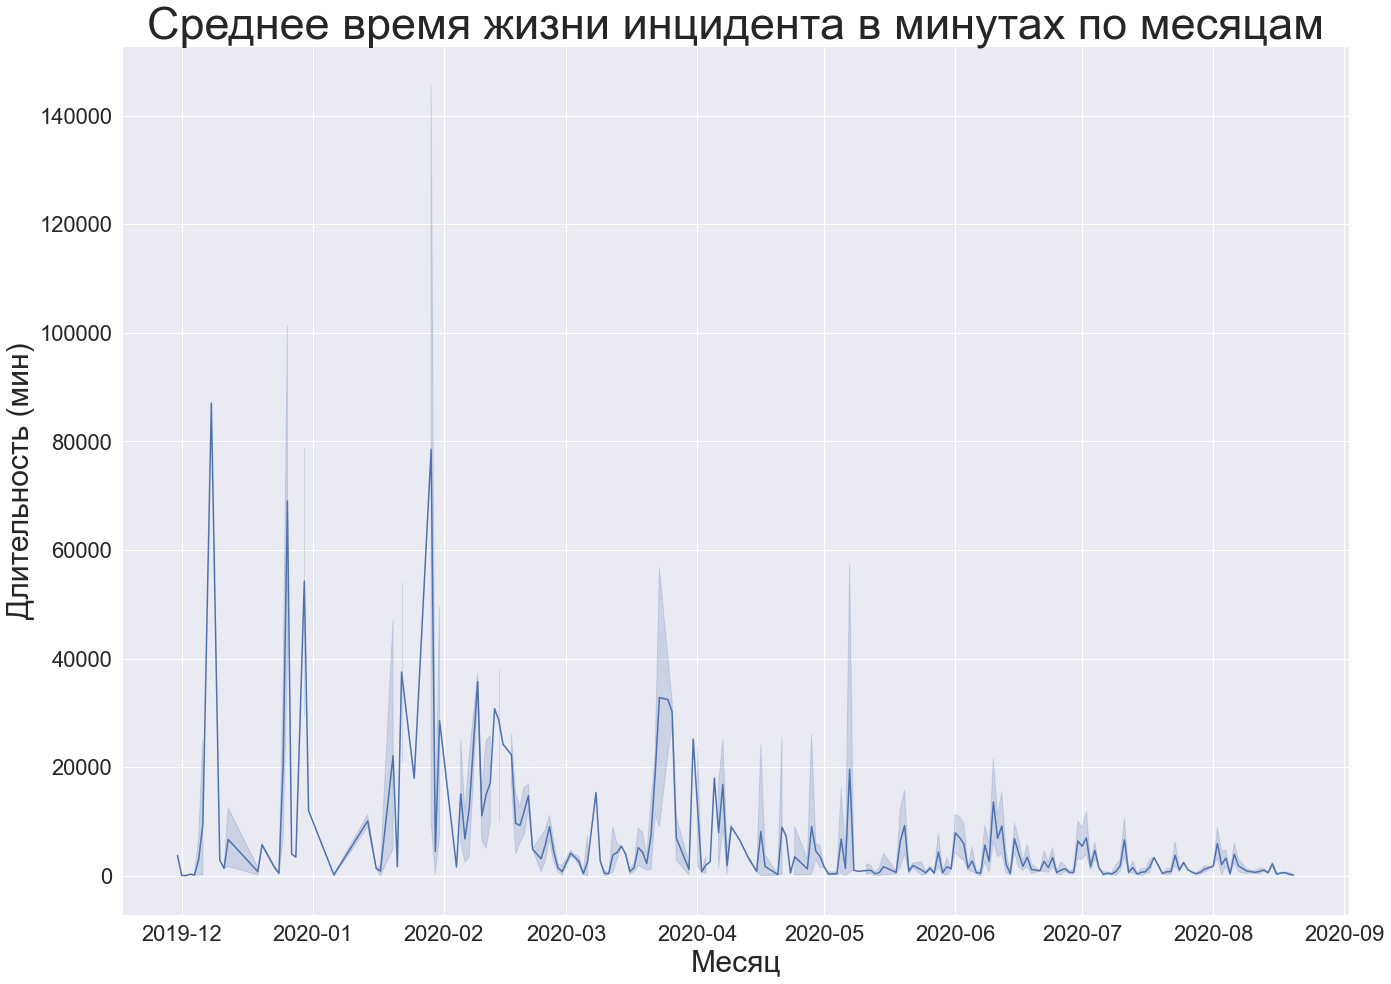

In [173]:
plt.figure(figsize=(22,16))
ax = sns.lineplot(data=clearedDeltaTime, x='createDate', y='delta_time_minutes')

ax.set_xlabel("Month",fontsize=30)
ax.set_ylabel("Duraition (min)",fontsize=30)

plt.title("Mean incident lifetime in minutes", fontsize = 45)

plt.show()

In [183]:
print(df['incidentMessage'].value_counts().nlargest(200))

Transaction rolled back because it has been marked as rollback-only                                                                                                                                                                                                                                                                            12
{"status":500,"series":16,"timestamp":"Jun 26, 2020 4:02:18 AM","message":"ErrorCode:BMP_HR.ONE_BPM_CAMUNDA_WORKER.1Message:Error requesting access token. Exception message:Error requesting access token.","code":1,"system":"BMP_HR"}                                                                                                        8
{"status":500,"series":16,"timestamp":"Jul 20, 2020 12:01:11 AM","message":"ErrorCode:BMP_HR.ONE_BPM_CAMUNDA_WORKER.1Message:status 500 reading CamundaAdapterFeign#assignAllActiveTaskToReplacement(String) Exception message:status 500 reading CamundaAdapterFeign#assignAllActiveTaskToReplacement(String)","code":1,"system":"B

In [208]:
def jsonParse(strr):
    try:
        if not strr:
            return ''
        
        if strr.startswith("{"):
            parsed = json.loads(strr)
            return parsed['message']
        
        return strr
    except:
        return ''


In [224]:
# Most popular incident messages sorted
df['incidentMessageParsed'] = df['incidentMessage'].apply(lambda x: jsonParse(x))
print(df['incidentMessageParsed'].value_counts().nlargest(20))

                                                                                                                                                                                                                                                             1444
ErrorCode:BMP_HR.ONE_BPM_CAMUNDA_WORKER.1Message:status 500 reading CamundaAdapterFeign#assignAllActiveTaskToReplacement(String) Exception message:status 500 reading CamundaAdapterFeign#assignAllActiveTaskToReplacement(String)                            969
ErrorCode:BMP_HR.ONE_BPM_CAMUNDA_WORKER.1Message:status 500 reading CamundaAdapterFeign#reassignBackAllActiveTasks(String) Exception message:status 500 reading CamundaAdapterFeign#reassignBackAllActiveTasks(String)                                        609
ErrorCode:BMP_HR.ONE_BPM_ORDER_JOURNAL.7Message:status 500 reading CeaAdapterFeign#saveDocument(CeaDocDto) Exception message:status 500 reading CeaAdapterFeign#saveDocument(CeaDocDto)                                           